# Ví dụ 1

## Cách 1

In [44]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

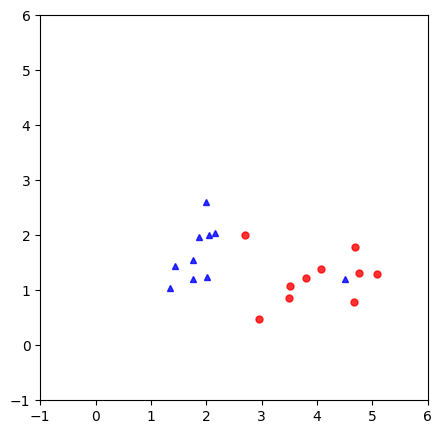

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()

ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [46]:
from cvxopt import matrix, solvers
C = 100

V = np.concatenate((X0.T, -X1.T), axis = 1)

K = matrix(V.T.dot(V))

q = matrix(-np.ones((2*N, 1)))

G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, q, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.23267347e-07 4.85674336e+01 9.99999981e+01 1.57381885e-07
  1.40373846e-07 5.28974755e-08 4.87560152e-07 1.81225362e-07
  9.27217960e-08 1.00000000e+02 9.01112775e-08 5.15612516e-08
  3.58687179e-07 3.18585409e-07 7.07041178e-07 9.76857085e+01
  6.09091270e-08 5.08817211e+01 1.76779299e-06 9.99999999e+01]]


In [47]:
S = np.where(l > 1e-5)[0] 
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2] 
XT = X.T 
VS = V[:, S]
lS = l[S]
yM = y.T[M]

XM = XT[M, :]

w_dual = VS.dot(lS).reshape(-1, 1)
print(w_dual.shape)
print(XM.shape)
print(yM.shape)
b_dual = np.mean(yM - XM.dot(w_dual))
print(w_dual.T, b_dual)

(2, 1)
(3, 2)
(3, 1)
[[-1.06640598  1.01378208]] 1.6623905770039993


## Cách 2

In [22]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) 
X1_bar = np.vstack((X1.T, np.ones((1, N)))) 
Z = np.hstack((X0_bar, - X1_bar)) 
lam = 1./C
def cost(w):
  u = w.T.dot(Z) 
  return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] 
def grad(w):
  u = w.T.dot(Z) 
  H = np.where(u < 1)[1]
  ZS = Z[:, H]
  g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
  g[-1] -= lam*w[-1] 
  return g
eps = 1e-6

In [23]:
def grad_descent(w0, eta):
  w = w0
  it = 0
  while it < 100000:
    it = it + 1
    g = grad(w)
    w -= eta*g
    if (it % 10000) == 1:
      print('iter %d' %it + ' cost: %f' %cost(w))
    if np.linalg.norm(g) < 1e-5:
      break
  return w

In [ ]:
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

/tmp/ipykernel_11309/846319303.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 1 cost: 24.312820
iter 10001 cost: 4.963527
iter 20001 cost: 4.969327
iter 30001 cost: 4.961336
iter 40001 cost: 4.961370
iter 50001 cost: 4.961404
iter 60001 cost: 4.961438
iter 70001 cost: 4.969322
iter 80001 cost: 4.969296
iter 90001 cost: 4.969269
[[-1.07049082  0.99874462]] [1.68169917]


## Cách 3

In [25]:
from sklearn.svm import SVC

y1 = y.reshape((2*N,))
X1 = X.T 
clf = SVC(kernel = 'linear', C = 100) 


clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-1.06600888  1.01354038]]
b =  [1.66151836]


# Thực hành 1

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
def predict_linear(w, b, X):
    return np.sign(w.T @ X + b).flatten()

def evaluate_and_plot(w, b, X, y_true, method_name=""):
    y_pred = np.sign(w.T @ X + b).flatten()
    acc = accuracy_score(y_true.flatten(), y_pred)
    cm = confusion_matrix(y_true.flatten(), y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f'confusion_matrix: {cm}')


In [ ]:
def svm_dual_cvxopt(C, X, y):
    V = np.concatenate((X0.T, -X1.T), axis=1)
    K = matrix(V.T @ V)
    q = matrix(-np.ones((2*N, 1)))
    G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))
    h = matrix(np.vstack((np.zeros((2*N, 1)), C * np.ones((2*N, 1)))))
    A = matrix(y.reshape((-1, 2*N)))
    b = matrix(np.zeros((1, 1)))
    sol = solvers.qp(K, q, G, h, A, b)
    l = np.array(sol['x'])

    S = np.where(l > 1e-5)[0]
    S2 = np.where(l < .999*C)[0]
    M = [val for val in S if val in S2]

    VS = V[:, S]
    lS = l[S]
    XM = X[:, M]
    yM = y[:, M]
    w = VS @ lS
    b = np.mean(yM.T - w.T @ XM)

    evaluate_and_plot(w, b, X, y)


def svm_gradient_descent(C, X, y):
    lam = 1. / C

    def cost(w):
        u = w.T @ Z
        return (np.sum(np.maximum(0, 1 - u)) + 0.5 * lam * np.sum(w*w)) - 0.5 * lam * w[-1]**2

    def grad(w):
        u = w.T @ Z
        H = np.where(u < 1)[1]
        ZS = Z[:, H]
        g = -np.sum(ZS, axis=1, keepdims=True) + lam * w
        g[-1] -= lam * w[-1]
        return g

    def grad_descent(w0, eta=0.001, tol=1e-5, max_iter=100000):
        w = w0.copy()
        for _ in range(max_iter):
            g = grad(w)
            w -= eta * g
            if np.linalg.norm(g) < tol:
                break
        return w

    w0 = np.random.randn(Z.shape[0], 1)
    w_all = grad_descent(w0)
    w, b = w_all[:-1], w_all[-1]
    evaluate_and_plot(w, b, X, y)


def svm_sklearn(C, X, y):
    clf = SVC(kernel='linear', C=C)
    clf.fit(X.T, y.flatten())
    w = clf.coef_.reshape(-1, 1)
    b = clf.intercept_[0]
    evaluate_and_plot(w, b, X, y)


In [58]:
svm_dual_cvxopt(100, X, y)
svm_gradient_descent(100, X, y)
svm_sklearn(100, X, y)

Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]


In [59]:
C_values = [1000, 200, 10, 0.5]
for C in C_values:
    print(f"C = {C}")
    svm_dual_cvxopt(C, X, y)
    svm_gradient_descent(C, X, y)
    svm_sklearn(C, X, y)



C = 1000
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
C = 200
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
C = 10
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
C = 0.5
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]
Accuracy: 90.00%
confusion_matrix: [[9 1]
 [1 9]]


# Thực hành 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
cancer_data = datasets.load_breast_cancer()
X = cancer_data.data
y = cancer_data.target  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: {cm}')

Accuracy: 96.49%
Confusion Matrix: [[ 59   4]
 [  2 106]]


# Ví dụ 2

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
data = pd.read_csv("/home/vitquay1708/Study_Space/ml/week_13/data/sonar.all-data.csv", header=None)
X = data.iloc[:, :-1].values       
y_raw = data.iloc[:, -1].values    
y = np.array([1 if label == 'M' else -1 for label in y_raw])    

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [68]:
C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: {cm}')

Accuracy: 79.37%
Confusion Matrix: [[21  7]
 [ 6 29]]


# Ví dụ 3

In [70]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [71]:
spambase = fetch_ucirepo(id=94)
X = spambase.data.features          
y_raw = spambase.data.targets      
y = y_raw.values.flatten()
y = np.where(y == 1, 1, -1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=42)

In [ ]:
C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: {cm}')

# Ví dụ 5

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/home/vitquay1708/Study_Space/ml/week_13/data/Admission_Predict.csv")
data.drop(columns=['Serial No.'],inplace=True)
threshold = 0.75
data['Label'] = data['Chance of Admit'] >= threshold
data['Label'] = data['Label'].astype(int)
data['Label'] = data['Label'].replace({0: -1, 1: 1})

In [75]:
X = data.drop(columns=['Chance of Admit', 'Label']).values
y = data['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [76]:
C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: {cm}')


Accuracy: 90.00%
Confusion Matrix: [[66  8]
 [ 4 42]]
